# Simulation of N-body system
By: Magnus Kvåle Helliesen

In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

## Body class
We make a class containing all relevant information for any given body. That is initial position, velocity and mass. In addition, we allow for updating of position and velocity for any given time.

In [2]:
# Let's make a class holding properties of a celestial body
class Body():
    def __init__(self,
                 position_0: tuple,
                 velocity_0: tuple,
                 mass: float):
        # Cheking for type errors
        if isinstance(position_0, tuple) is False:
            raise TypeError('position_0 must be tuple')
        if all(isinstance(x, float) or isinstance(x, int) for x in position_0) is False:
            raise TypeError('all values of position_0 must be float or int')

        if isinstance(velocity_0, tuple) is False:
            raise TypeError('velocity_0 must be tuple')
        if all(isinstance(x, float) or isinstance(x, int) for x in velocity_0) is False:
            raise TypeError('all values of velocity_0 must be int')

        if (isinstance(mass, float) or isinstance(mass, int)) is False:
            raise TypeError('mass must be float or int')

        # Setting attributes that cannot be changed
        self._position_0 = position_0
        self._velocity_0 = velocity_0
        self._mass = mass

        # Setting attributes that can be changed
        self._position_t = position_0
        self._velocity_t = velocity_0

    @property
    def position_0(self):
        return self._position_0

    @property
    def velocity_0(self):
        return self._velocity_0

    @property
    def mass(self):
        return self._mass

    @property
    def position_t(self):
        return self._position_t

    @property
    def velocity_t(self):
        return self._velocity_t

    @position_t.setter
    def position_t(self, value):
        if isinstance(value, tuple) is False:
            raise TypeError('position must be tuple')
        if all(isinstance(x, float) for x in value) is False:
            raise ValueError('all values of position must be float')
        self._position_t = value

    @velocity_t.setter
    def velocity_t(self, value):
        if isinstance(value, tuple) is False:
            raise TypeError('velocity must be tuple')
        if all(isinstance(x, float) for x in value) is False:
            raise ValueError('all values of velocity must be float')
        self._velocity_t = value

    def __str__(self):
        return f'Body at {self.position_t} with velocity {self.velocity_t} and mass {self.mass}'

    def __repr__(self):
        return self.__str__()

## System class
We make a class that holds instances of body classes. The system class has a method to simulate how the bodies move over time according to
$\vec{F} = m\vec{a} \iff \vec{a} = \vec{F}/m$. We use the following approximations given some chosen $\Delta t$:
$$
    \vec{v}'(t)=a(t) \rightarrow \vec{v}(t+1)\approx \vec{v}(t)+\Delta t \vec{a}(t),
$$
$$
    \vec{x}'(t)=\vec{x}(t) \rightarrow \vec{x}(t+1)\approx \vec{x}(t)+\Delta t \vec{v}(t),
$$
which allow us to approximate positions using intitial conditions for positions and velocity (we assume initial accelration is zero).

In [3]:
# Let's make a class that holds a bunch of celestial bodies
class System():
    def __init__(self, G: float, *bodies: Body):
        # Cheking for type errors
        if all(isinstance(x, Body) for x in bodies) is False:
            raise TypeError('all bodies must be Body object')

        if (isinstance(G, float) or isinstance(G, int)) is False:
            raise TypeError('G must be float or int')

        # Setting attributes that cannot be changed
        self._G = G
        self._bodies = bodies

    @property
    def G(self):
        return self._G

    @property
    def bodies(self):
        return self._bodies

    def __str__(self):
        return f'System with {len(self.bodies)} bodies and gravitational constant {self.G:.2f}'

    def __repr__(self):
        return self.__str__()

    # Method that simulates object trajectories
    def simulate(self, N: int, delta_t: float):
        # Checking for type errors
        if isinstance(N, int) is False:
            raise TypeError('N must be int')

        if isinstance(delta_t, float) is False:
            raise TypeError('delta_t must be float')

        # Setting up for simulation
        t = np.zeros(N+1)
        v, x = {}, {}
        for i, body in enumerate(self.bodies):
            v[i] = np.zeros((N+1, 2))
            x[i] = np.zeros((N+1, 2))
            v[i][0] = body.velocity_0
            x[i][0] = body.position_0

        # Simulating
        for n in range(N):
            t[n+1] = delta_t+t[n]
            for i, body in enumerate(self.bodies):
                # Calculate net forces on body from every other body
                F = np.zeros(2)
                for other_body in [x for x in self.bodies if x != body]:
                    r = np.array(body.position_t)-np.array(other_body.position_t)
                    r_norm = np.linalg.norm(r)
                    r_hat = r/r_norm
                    F += -(self.G*body.mass*other_body.mass/r_norm**2)*r_hat

                v[i][n+1] = v[i][n]+delta_t*F/body.mass
                x[i][n+1] = x[i][n]+delta_t*v[i][n]

            # Update position and velocity in body instances
            for i, body in enumerate(self.bodies):
                body.position_t = tuple(x[i][n])
                body.velocity_t = tuple(v[i][n])

        # Returning simulation results
        return t, x

## Setting up and simulating
We set up a few bodies and put them into a system. We then simulate the system and plot the trajectories.

In [4]:
# Defining some bodies
body1 = Body((2, 2), (-1, 1), 5)
body2 = Body((-2, -2), (1, -1), 5)
body3 = Body((0, 0), (0, 0), 3)

# And puting them in a system
system1 = System(2, body1, body2, body3)
system1

System with 3 bodies and gravitational constant 2.00

In [5]:
print(*system1.bodies, sep='\n')

Body at (2, 2) with velocity (-1, 1) and mass 5
Body at (-2, -2) with velocity (1, -1) and mass 5
Body at (0, 0) with velocity (0, 0) and mass 3


In [6]:
# We can now simulate how they move about
N = 20000
delta_t = 0.00125
t, x = system1.simulate(N, delta_t)

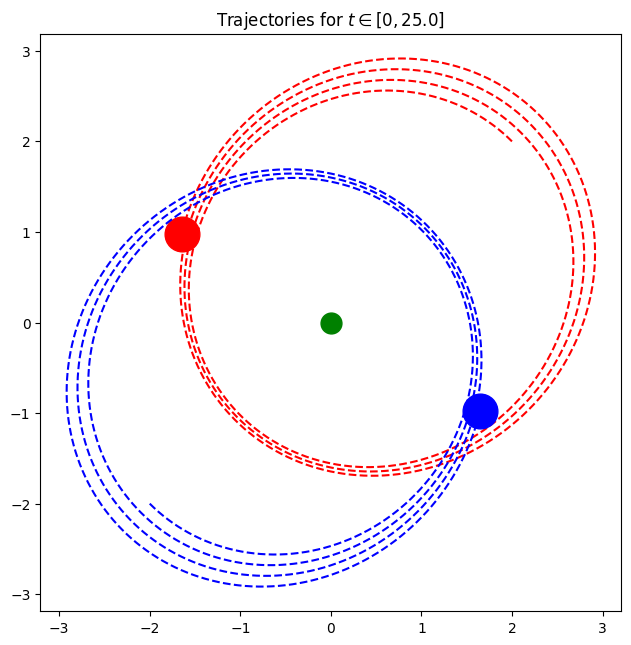

In [7]:
# And plot the curves that they trace out (this should be animated)
plt.figure(figsize=(7.5, 7.5))
plt.plot(x[0][:,0], x[0][:,1], 'r--')
plt.plot(x[0][-1,0], x[0][-1:,1], 'ro', ms=5*5)
plt.plot(x[1][:,0], x[1][:,1], 'b--')
plt.plot(x[1][-1,0], x[1][-1:,1], 'bo', ms=5*5)
plt.plot(x[2][:,0], x[2][:,1], 'g--')
plt.plot(x[2][-1,0], x[2][-1:,1], 'go', ms=3*5)
plt.axis('equal')
plt.title(f'Trajectories for $t \in [0, {N*delta_t}]$')
plt.show()